In [4]:
import torch
import torch.nn as nn	
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5), (0.5)) # normalize [0, 1] to [-1, 1]
])

In [7]:
batch_size = 128

dataset = datasets.mnist.MNIST(root='./DataSet/mnist', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
latent_dim = 100

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
			nn.Linear(latent_dim, 256),
			nn.LeakyReLU(0.2),
			nn.Linear(256, 512),
			nn.LeakyReLU(0.2),
			nn.Linear(512, 28*28),
			nn.Tanh() # [-1, 1]
		)
    
    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28) # (batch_size, 1, 28, 28)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
			nn.Linear(28 * 28, 512),
			nn.LeakyReLU(0.2),
			nn.Linear(512, 256),
			nn.LeakyReLU(0.2),	
			nn.Linear(256, 1),
			nn.Sigmoid() # proability (real or fake)
		)
        
    def forward(self, img):
        flat = img.view(img.size(0), -1)
        return self.model(flat)

In [11]:
generator = Generator()
discriminator = Discriminator()

In [12]:
criterian = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
epochs = 20

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        
        real_img = real_imgs.to(device)
        
        batch_size = real_imgs.size(0) # (batch_size, 1, 28, 28)
        
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # train discriminator
        optimizer_D.zero_grad()
        
        outputs = discriminator(real_imgs)
        d_loss_real = criterian(outputs, real_labels)
        
        z = torch.randn(batch_size, latent_dim)
        fake_imgs = generator(z)
        
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterian(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        optimizer_D.step()
        
        # train generator from discriminator
        optimizer_G.zero_grad()
        
        z = torch.randn(batch_size, latent_dim)
        generator_output = generator(z)
        outputs = discriminator(generator_output)
        
        g_loss = criterian(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

Epoch [1/20]  D_loss: 0.0909  G_loss: 5.3434
Epoch [2/20]  D_loss: 0.4774  G_loss: 3.0146
Epoch [3/20]  D_loss: 0.4002  G_loss: 3.3794
Epoch [4/20]  D_loss: 1.8962  G_loss: 1.1488
Epoch [5/20]  D_loss: 0.4339  G_loss: 1.8632
Epoch [6/20]  D_loss: 1.1143  G_loss: 1.4890
Epoch [7/20]  D_loss: 0.5946  G_loss: 1.9148
Epoch [8/20]  D_loss: 1.1518  G_loss: 1.7161
Epoch [9/20]  D_loss: 0.2028  G_loss: 2.7469
Epoch [10/20]  D_loss: 0.1407  G_loss: 3.6114
Epoch [11/20]  D_loss: 0.2775  G_loss: 5.7272
Epoch [12/20]  D_loss: 0.3271  G_loss: 3.9400
Epoch [13/20]  D_loss: 0.2330  G_loss: 4.0628
Epoch [14/20]  D_loss: 0.8824  G_loss: 3.2118
Epoch [15/20]  D_loss: 0.4381  G_loss: 3.3585
Epoch [16/20]  D_loss: 0.6818  G_loss: 3.2367
Epoch [17/20]  D_loss: 0.4528  G_loss: 3.8990
Epoch [18/20]  D_loss: 0.3222  G_loss: 2.9716
Epoch [19/20]  D_loss: 0.3509  G_loss: 3.0013
Epoch [20/20]  D_loss: 0.5307  G_loss: 4.6923


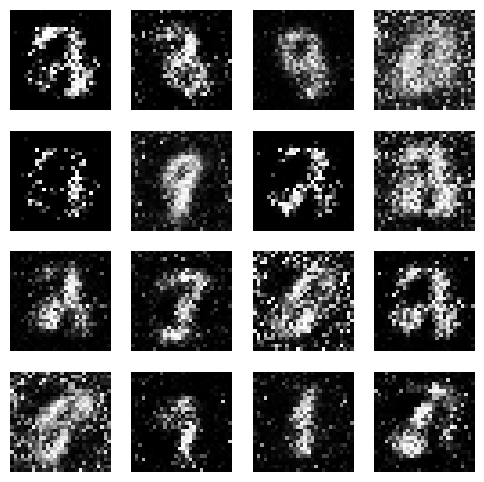

In [14]:
z = torch.randn(16, latent_dim)
fake_imgs = generator(z).detach()

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fake_imgs[i].view(28,28), cmap="gray")
    plt.axis("off")
plt.show()